In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score
import json
import matplotlib.pyplot as plt

In [2]:
df_sc = pd.read_pickle("../data/df_uni_bi_tri_normalized_SC.pickle")
df_ic = pd.read_pickle("../data/df_uni_bi_tri_normalized_IC.pickle")
df = df_sc.merge(df_ic, on = 'uniform_id')
df.head()

TF_uni_POS                                                    \
                  ADJ       ADP       ADV       AUX     CCONJ       DET   
uniform_id                                                                
ee_1         0.092952  0.021455  0.068043  0.039998  0.024544  0.025583   
ee_12        0.098369  0.036429  0.055563  0.032016  0.009287  0.019285   
ee_16        0.090635  0.023712  0.068675  0.038582  0.024094  0.020737   
ee_19        0.088778  0.017851  0.059174  0.045878  0.024351  0.029278   
ee_2         0.089408  0.022145  0.058950  0.048772  0.012299  0.023303   

                                                    ... FF_tri_IC            \
                NOUN       NUM      PART      PRON  ...        21        22   
uniform_id                                          ...                       
ee_1        0.069455  0.162422  0.023479  0.039490  ...  0.172410  0.168674   
ee_12       0.071990  0.131555  0.045870  0.048824  ...  0.153643  0.168770   
ee_16       0.077147  0.134208  0.036140  0.038658  ...  0.169928  0.177039   
ee_19       0.070724  0.106533  0.031707  0.047643  ...  0.131176  0.126908   
ee_2        0.082544  0.021347  0.030941  0.029995  ...  0.196307  0.171843   

                                                                        \
                  23        24        25        26        27        28   
uniform_id                                                               
ee_1        0.176803  0.271371  0.263921  0.179121  0.152872  0.122909   
ee_12       0.172643  0.447568  0.384881  0.195568  0.280024  0.093657   
ee_16       0.168858  0.243441  0.298895  0.218182  0.117245  0.131791   
ee_19       0.155958  0.312220  0.218795  0.161457  0.149022  0.104540   
ee_2        0.210000  0.280437  0.285829  0.284697  0.304705  0.182424   

                                
                  30        31  
uniform_id                      
ee_1        0.174318  0.176566  
ee_12       0.275122  0.191923  
ee_16       0.153952  0.238349  
ee_19       0.084703  0.136146  
ee_2        0.184710  0.248796  

[5 rows x 5292 columns]

In [3]:
columns = df.columns.to_list()
unigrams = np.unique([x[0] for x in columns if "uni" in x[0]])
unigrams

array(['FF_uni_IC', 'FF_uni_POS', 'FF_uni_PTB', 'FF_uni_UD', 'FP_uni_IC',
       'FP_uni_POS', 'FP_uni_PTB', 'FP_uni_UD', 'TF_uni_IC', 'TF_uni_POS',
       'TF_uni_PTB', 'TF_uni_UD'], dtype='<U10')

In [4]:
df_unigrams = df[unigrams].reset_index()
df_unigrams.columns = df_unigrams.columns.map('{0[0]}|{0[1]}'.format) 
df_unigrams = df_unigrams.rename(columns={"uniform_id|":"label"})
df_unigrams.label = df_unigrams.label.apply(lambda x: x.split("_")[0])
df_unigrams.head()

,label,FF_uni_IC|1,FF_uni_IC|2,FF_uni_IC|3,FF_uni_IC|4,FF_uni_IC|5,FF_uni_IC|6,FF_uni_IC|7,FF_uni_IC|8,FF_uni_IC|9,...,TF_uni_UD|flat,TF_uni_UD|mark,TF_uni_UD|nmod,TF_uni_UD|nsubj,TF_uni_UD|nummod,TF_uni_UD|obj,TF_uni_UD|obl,TF_uni_UD|punct,TF_uni_UD|root,TF_uni_UD|xcomp
0,ee,0.009998,0.022705,0.024319,0.034689,0.048257,0.039821,0.066915,0.051897,0.080115,...,0.051559,0.025653,0.052003,0.070146,0.043612,0.058621,0.071714,0.067541,0.118800,0.156264
1,ee,0.001817,0.030677,0.018616,0.032883,0.043340,0.055629,0.075218,0.049044,0.066405,...,0.082191,0.050539,0.059002,0.076552,0.000000,0.060519,0.069193,0.092708,0.104076,0.061877
2,ee,0.013617,0.022257,0.021975,0.032067,0.040613,0.054505,0.069496,0.058006,0.069886,...,0.064998,0.045481,0.070647,0.063071,0.000000,0.058986,0.089270,0.035357,0.102874,0.134507
3,ee,0.010764,0.019825,0.025643,0.034172,0.042669,0.044059,0.052289,0.041911,0.043458,...,0.087437,0.037766,0.069645,0.072129,0.000000,0.058285,0.078847,0.116565,0.095125,0.082014
4,ee,0.000000,0.024708,0.025200,0.040379,0.055962,0.058344,0.079565,0.070766,0.077714,...,0.053401,0.030304,0.063101,0.062775,0.000000,0.081080,0.076505,0.045024,0.103300,0.021103


In [5]:
def ERS(clf, df, l1, l2):
    index1 = list(clf.classes_).index(l1)
    index2 = list(clf.classes_).index(l2)

    lang1 = df[df.label == l1]
    X1 = lang1.iloc[:,1:]

    lang2 = df[df.label == l2]  
    X2 = lang2.iloc[:,1:]

    p1 = clf.predict_proba(X1)[:,index2]
    p2 = clf.predict_proba(X2)[:,index1]
    
    return (p1.sum() + p2.sum())/(len(X1) + len(X2))

In [6]:
y = df_unigrams.iloc[:,0]
X = df_unigrams.iloc[:,1:]
n_samples = X.shape[0]
logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0, max_iter=500)

In [7]:
results = []

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
for i, (train_index, test_index) in enumerate(cv.split(X)):
    print(f"Fold {i}")
    
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]
    
    logreg.fit(X_train, y_train)
    languages = list(logreg.classes_)
    
    for i, l1 in enumerate(languages):
        for l2 in languages:
            results.append([l1, l2, ERS(logreg, df_unigrams, l1, l2)])

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


In [8]:
with open("../data/outputs/language_lookup.json") as json_file:
    language_lookup = json.load(json_file)
rename_lang = {'nld':'du', 'ekk': 'ee', 'eng':'en', 'fin': 'fi', 'deu': 'ge', 'ell':'gr', 'heb':'he',
 'ita':'it', 'nor':'no', 'rus':'ru', 'spa':'sp', 'tur':'tr'}

In [9]:
df_ERS = pd.DataFrame(results, columns=["L1", "L2", "ERS_score"])
df_ERS = df_ERS.sort_values(["L1", "L2"])
df_ERS = df_ERS.groupby(["L1", "L2"]).agg(
    ERS_mean=("ERS_score", np.mean),
    ERS_min=("ERS_score", np.min),
    ERS_max=("ERS_score", np.max)
).reset_index()

df_ERS_matrix = df_ERS.pivot(index="L1", columns="L2", values="ERS_mean")

df_ERS_long = df_ERS.drop(df_ERS[df_ERS.L1 >= df_ERS.L2].index)
df_ERS_long["pair"] = df_ERS_long.apply(lambda row: (row.L1, row.L2), axis=1)
df_ERS_long = df_ERS_long[["pair", "ERS_mean", "ERS_min", "ERS_max"]]


In [10]:
df_LS = pd.read_csv(r"../data/outputs/linguistic_similarities.csv").rename(columns = rename_lang)
df_LS["lang"] = df_LS['Unnamed: 0'].replace(rename_lang).values
df_LS = df_LS.drop(columns=['Unnamed: 0'])

df_LS_matrix = df_LS.set_index("lang")

df_LS_long = pd.melt(df_LS, id_vars="lang")
df_LS_long = df_LS_long.sort_values(["lang", "variable"])
df_LS_long = df_LS_long.drop(df_LS_long[df_LS_long.lang >= df_LS_long.variable].index)
df_LS_long["pair"] = df_LS_long.apply(lambda row: (row.lang, row.variable), axis=1)
df_LS_long = df_LS_long[["pair", "value"]]
df_LS_long = df_LS_long.rename(columns={"value":"LS"})

In [32]:
df_sim = df_ERS_long.merge(df_LS_long, on="pair")
df_sim.head()

,pair,ERS_mean,ERS_min,ERS_max,LS
0,"(ee, en)",0.000817,0.000119,0.005301,0.698653
1,"(ee, fi)",0.011812,0.001071,0.041865,0.870097
2,"(ee, ge)",0.002790,0.000247,0.010595,0.712649
3,"(ee, he)",0.002989,0.000248,0.015371,0.716547
4,"(ee, it)",0.009231,0.000536,0.024906,0.734377


In [38]:
df_sim[["ERS_min", "ERS_max"]].values.T.shape

(2, 21)

C:\Users\azi\Miniconda3\envs\nlp\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


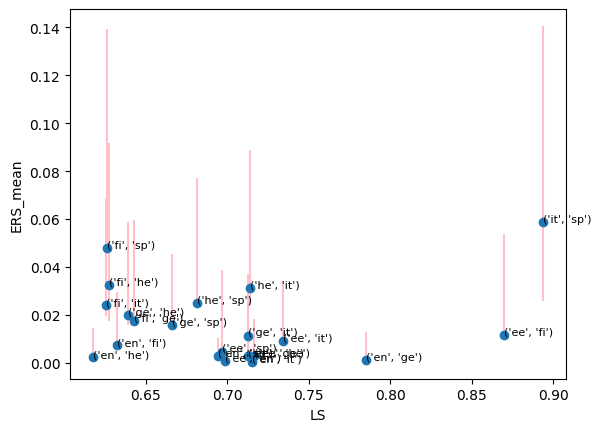

In [40]:
ax = df_sim.plot.scatter(x="LS", y="ERS_mean")
plt.errorbar(df_sim.LS, df_sim.ERS_mean, yerr=df_sim[["ERS_min", "ERS_max"]].T.values, fmt="o", ecolor="pink")

for i, txt in enumerate(df_sim.pair[:21]):
    ax.annotate(txt, (df_sim.LS.iat[i], df_sim.ERS_mean.iat[i]), fontsize=8)
plt.show()

In [13]:
df_sim[["ERS_mean", "LS"]].corr()

,ERS_mean,LS
ERS_mean,1.000000,0.116888
LS,0.116888,1.000000


In [14]:
from scipy.cluster.hierarchy import ward, dendrogram

In [15]:
df_LS_matrix

,en,ee,fi,ge,he,it,sp
lang,,,,,,,
en,1.000000,0.698653,0.632281,0.785334,0.617412,0.715152,0.694413
ee,0.698653,1.000000,0.870097,0.712649,0.716547,0.734377,0.696622
fi,0.632281,0.870097,1.000000,0.642963,0.627488,0.625773,0.626330
ge,0.785334,0.712649,0.642963,1.000000,0.639189,0.712827,0.666290
he,0.617412,0.716547,0.627488,0.639189,1.000000,0.714295,0.681355
it,0.715152,0.734377,0.625773,0.712827,0.714295,1.000000,0.894097
sp,0.694413,0.696622,0.626330,0.666290,0.681355,0.894097,1.000000


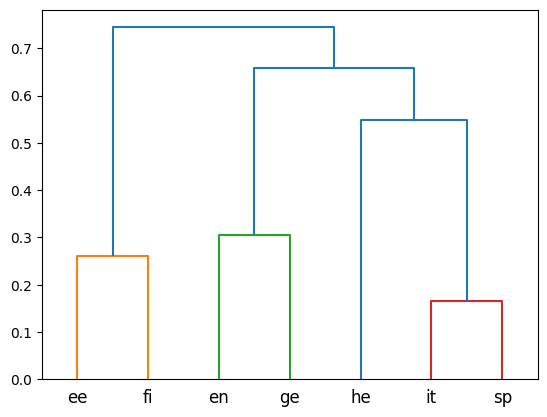

In [16]:
tree = ward(df_LS_matrix)
fig, ax = plt.subplots()
dn = dendrogram(tree, ax=ax, labels=df_LS_matrix.index)
# ax.set_yticks([])
plt.show()

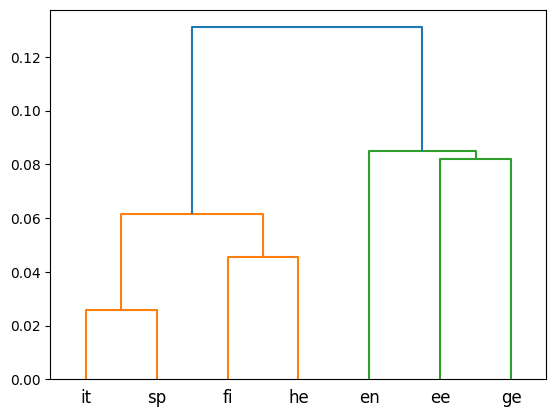

In [17]:
tmp = df_ERS_matrix.copy()
np.fill_diagonal(tmp.values, 0)
max_val = tmp.max().max()
np.fill_diagonal(tmp.values, max_val)

tree = ward(tmp)
fig, ax = plt.subplots()
dn = dendrogram(tree, ax=ax, labels=tmp.index)
# ax.set_yticks([])
plt.show()

C:\Users\azi\Miniconda3\envs\nlp\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


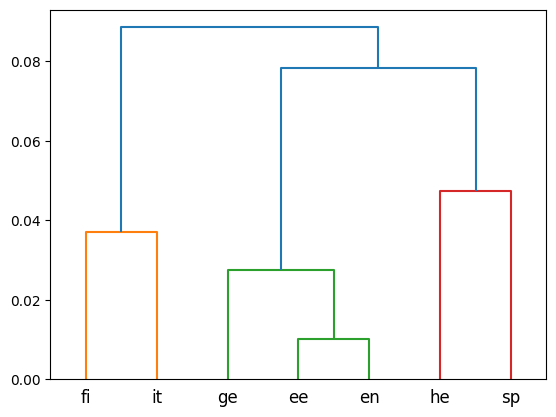

In [18]:
tmp = df_ERS_matrix.copy()
np.fill_diagonal(tmp.values, 0)
# max_val = tmp.max().max()
# np.fill_diagonal(tmp.values, max_val)

tree = ward(tmp)
fig, ax = plt.subplots()
dn = dendrogram(tree, ax=ax, labels=tmp.index)
# ax.set_yticks([])
plt.show()

In [19]:
# how to do apply only on diagonals??

tmp = df_ERS_matrix.copy()
# tmp = tmp[tmp]
# np.fill_diagonal(tmp.values, 0)
# max_val = tmp.max().max()
# np.fill_diagonal(tmp.values, max_val)
np.diag(tmp)

# tree = ward(tmp)
# fig, ax = plt.subplots()
# dn = dendrogram(tree, ax=ax, labels=tmp.index)
# # ax.set_yticks([])
# plt.show()

array([0.96906465, 0.98920063, 0.85050501, 0.93921622, 0.88533062,
       0.88775292, 0.81700403])